In [37]:
import networkx as nx
import numpy as np

def simulate_deffuant_model(G, n_iter=100, threshold=0.5, convergence = 0.5):
    """Simulates the Deffuant model on the given graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph on which to simulate the model.
    n_iter : int
        The number of iterations to run the simulation for.
    threshold : float
        The threshold value used in the model.
    convergence : float
        The convergence value used in the model.

    Returns
    -------
    list of networkx.Graph
        A list of graphs, where each graph represents the state of the network at a given time step.
    """
    # initialize node attributes
    for node in G.nodes():
        G.nodes[node]['opinion'] = np.random.uniform(-1, 1)

    graphs = []
    # run simulation
    for t in range(n_iter):
        # create a graph at current time step to store effective network
        G_eff = nx.Graph()
        for u, v, data in G.edges(data=True):
            G_eff.add_node(u)
            G_eff.add_node(v)
            diff = abs(G.nodes[u]['opinion'] - G.nodes[v]['opinion'])
            if diff > threshold:
                continue

            G_eff.add_edge(u, v)
            
            # update opinions
            G.nodes[u]['opinion'] += convergence * (G.nodes[v]['opinion'] - G.nodes[u]['opinion'])
            G.nodes[v]['opinion'] += convergence * (G.nodes[u]['opinion'] - G.nodes[v]['opinion'])

        graphs.append(G_eff)

    return graphs


In [59]:
BA_graph = nx.barabasi_albert_graph(1000, 4, seed=42, initial_graph=None)
lattice = nx.grid_2d_graph(7, 7, periodic=False, create_using=None)

In [60]:
res = simulate_deffuant_model(BA_graph, 1000, 0.3, 0.3)

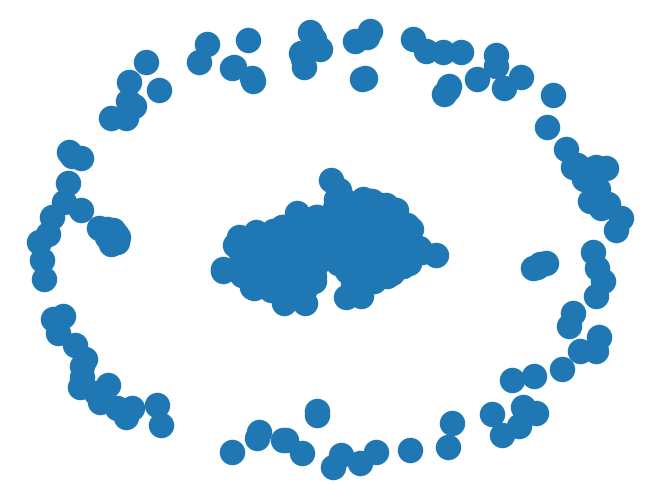

In [62]:
nx.draw(res[-1], nx.spring_layout(res[-1]))